# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задача обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 
Решить задачу можно как с помощью BERT, так и без этой нейронки.  

**План работы**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`.  
Столбец *'text'* содержит текст комментария.  
Столбец *'toxic'* — целевой признак.

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/5.3 MB 1.4 MB/s eta 0:00:04
      --------------------------------------- 0.1/5.3 MB 1.2 MB/s eta 0:00:05
      --------------------------------------- 0.1/5.3 MB 751.6 kB/s eta 0:00:07
     - -------------------------------------- 0.1/5.3 MB 853.3 kB/s eta 0:00:07
     - -------------------------------------- 0.2/5.3 MB 930.9 kB/s eta 0:00:06
     -- ------------------------------------- 0.3/5.3 MB 1.1 MB/s eta 0:00:05
     -- ------------------------------------- 0.4/5.3 MB 1.3 MB/s eta 0:00:04
     --- ------------------------------------ 0.5/5.3 MB 1.4 MB/s eta 0:00:04
     ---- ----------------------------------- 0.6/5.3 MB 1.6 MB/s eta 0:00:03
     ------ --------------------------------- 0.9/5.3 MB 2.1 MB/s eta 0:00:03
     -------- ------------------------------- 1.1/5.3 MB 2.2 MB/s eta 0:00:02
     -

In [2]:
!pip install scikit-learn imbalanced-learn
!pip install torch
!pip install catboost

In [13]:
# Импортируем библиотеки 
import os
import time
import warnings
import torch 
import transformers
from transformers import(
    BertTokenizer, 
    BertModel,
    BertConfig, 
    AutoTokenizer, 
    AutoModel
)
import imblearn
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import tqdm
from tqdm import notebook
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


STATE=42
SIZE=0.3

## 1. Загрузка и подготовка данных

In [14]:
# Путь к файлу 
file_path = os.path.join('https://code.s3.yandex.net/datasets/toxic_comments.csv')

# Загрузим данные в DataFrame
toxic_comments = pd.read_csv(file_path)


toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [15]:
toxic_comments.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


**В данных представлено 159292 записи. Проверим на наличие пропущенных значений и дубликатов.**

In [16]:
# Проверка на пропущенные значения
missing_values = toxic_comments.isnull().sum()
print(f"Пропущенные значения по столбцам:\n{missing_values}\n")

# Проверка на дубликаты
duplicates_count = toxic_comments.duplicated().sum()
print(f"Общее количество дубликатов: {duplicates_count}")


Пропущенные значения по столбцам:
Unnamed: 0    0
text          0
toxic         0
dtype: int64

Общее количество дубликатов: 0


**Пропусков и дубликатов в данных не обнаружено.**

In [17]:
# Выводим уникальные значения в столбце 'toxic' и их количества
target_counts = toxic_comments['toxic'].value_counts()
print(f"Значения целевого признака и их количество:\n{target_counts}")


Значения целевого признака и их количество:
toxic
0    143106
1     16186
Name: count, dtype: int64


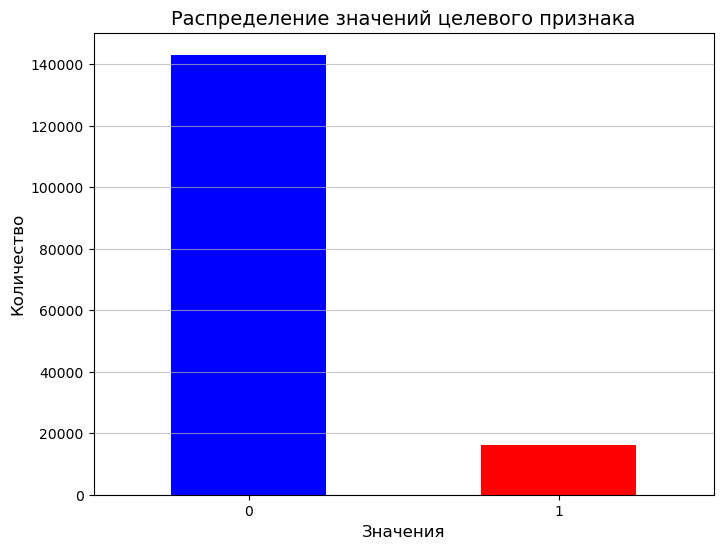

In [18]:
plt.figure(figsize=(8, 6))
target_counts.plot.bar(color=['blue', 'red'])
plt.title('Распределение значений целевого признака', fontsize=14)
plt.xlabel('Значения', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()

In [19]:
# Посмотрим соотношение данных
ratio = round(target_counts[0] / target_counts[1], 2)
print(f"Соотношение значений: {ratio}")

Соотношение значений: 8.84


**Данные явно не сбалансированы:** количество значений 0 почти в 9 раз превышает количество значений 1. Этот дисбаланс негативно повлияет на точность модели в предсказании меньшего класса. Чтобы модели могли корректно работать, нужно учесть дисбаланс классов. Для этого, во-первых, при разделении данных на тренировочную и тестовую выборки следует применять стратификацию. Во-вторых, можно либо сбалансировать тренировочную выборку с помощью методов сэмплирования. 

**Для подготовки текстов к обучению моделей используем BERT. Учитывая, что нейронные сети требуют значительных вычислительных ресурсов, обучение на полном наборе данных может занять много времени. Чтобы ускорить процесс, выберем подвыборку из 10,000 записей случайным образом.**

In [20]:
# Создадим подвыборку из 10,000 случайных записей
sample_size = 10000
toxic_comments_sample = toxic_comments.sample(sample_size, random_state=STATE)

# Рассчитаем и выведем соотношение классов в подвыборке
class_counts = toxic_comments_sample['toxic'].value_counts()
class_ratio = round(class_counts[0] / class_counts[1], 2)

print(f"Количество классов в выборке:\n{class_counts}")
print(f"Соотношение классов: {class_ratio}")


Количество классов в выборке:
toxic
0    8995
1    1005
Name: count, dtype: int64
Соотношение классов: 8.95


**Лемматизация не требуется, также у BERT есть свой токенизатор**

In [21]:
# Инициализация токенизатора и модели Toxic-BERT
model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [22]:
# Токенизация текста с использованием лямбда-функции
tokenized = toxic_comments_sample['text'].apply(
    lambda text: tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
)


In [23]:
# Нахождение максимальной длины токенизированных последовательностей
max_token_length = max(len(tokens) for tokens in tokenized.values)

print(f'Максимальная длина токена: {max_token_length}')


Максимальная длина токена: 512


Для работы модели BERT необходимо, чтобы все токенизированные последовательности имели одинаковую длину. Это достигается с помощью метода padding, который добавляет специальные токены (например, 0) к коротким последовательностям. Кроме того, тексты, длина которых превышает установленный лимит (512 токенов), автоматически усекаются до заданной длины. Таким образом, метод padding обеспечивает совместимость данных с архитектурой модели.

In [24]:
max_len = 512  # Указываем максимальную длину
padded = np.array([tokens[:max_len] + [0] * max(0, max_len - len(tokens)) for tokens in tokenized.values])

In [25]:
# Создание маски внимания 
attention_mask = (padded != 0).astype(int)

# Проверяем размерность маски
print(f"Размерность маски внимания: {attention_mask.shape}")


Размерность маски внимания: (10000, 512)


In [26]:
# Инициализация конфигурации и модели напрямую 
config = BertConfig.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


In [28]:
# Определяем устройство для выполнения вычислений (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Переносим модель на устройство
model = model.to(device)

# Размер батча
batch_size = 100

# Список для хранения эмбеддингов
embeddings = []

# Преобразуем данные и маску в тензоры заранее и переносим на устройство
padded_tensor = torch.LongTensor(padded).to(device)
attention_mask_tensor = torch.LongTensor(attention_mask).to(device)

# Получение эмбеддингов батчами
for i in notebook.tqdm(range(padded_tensor.shape[0] // batch_size), desc="Получение эмбеддингов"):
    # Извлекаем текущий батч
    batch = padded_tensor[batch_size * i: batch_size * (i + 1)]
    attention_mask_batch = attention_mask_tensor[batch_size * i: batch_size * (i + 1)]

    # Получаем эмбеддинги без расчёта градиентов
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    # Извлекаем CLS-токены, перемещаем на CPU и преобразуем в numpy
    embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

# Объединяем все эмбеддинги в один массив
embeddings = np.vstack(embeddings)
print("Эмбеддинги успешно получены.")

Используемое устройство: cuda


Получение эмбеддингов:   0%|          | 0/100 [00:00<?, ?it/s]

Эмбеддинги успешно получены.


In [29]:
# Собираем эмбеддинги в матрицу признаков 
features = np.vstack(embeddings)


In [30]:
# Выделяем признаки и целевую переменную
X, y = features, toxic_comments_sample['toxic']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=SIZE,
    random_state=STATE,
    stratify=y  # Сохраняем пропорции 
)

# Проверяем размеры выборок с поясняющим текстом
print(f"Размер тренировочных данных: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Размер тестовых данных: X_test={X_test.shape}, y_test={y_test.shape}")


Размер тренировочных данных: X_train=(7000, 768), y_train=(7000,)
Размер тестовых данных: X_test=(3000, 768), y_test=(3000,)


In [31]:
# Составим пайплайн подготовки данных и обучения модели
pipeline = Pipeline(
    [
        ('sample', SMOTE(random_state=STATE)),
        ('models', LogisticRegression(solver='liblinear',
                                      random_state=STATE))
    ]
)

pipeline

Pipeline(steps=[('sample', SMOTE(random_state=42)),
                ('models',
                 LogisticRegression(random_state=42, solver='liblinear'))])

**Выводы по предобработке данных:**

- **Данные успешно загружены и проверены на наличие пропусков и дубликатов. Пропуски и дубликаты отсутствуют.**

- **Выявлен дисбаланс классов в целевой переменной, что требует корректировки при обучении модели.**

- **Предобработка текстов выполнена с использованием модели BERT, которая включает собственный токенизатор. Для ускорения обработки случайным образом отобрано 10,000 наблюдений.**

-**Данные разделены на тренировочную и тестовую выборки:**

- **Размер тренировочной выборки: X_train=(7000, 768), y_train=(7000,)**

- **Размер тестовой выборки: X_test=(3000, 768), y_test=(3000,)** 

**Для обучения модели составлен пайплайн, включающий сэмплирование данных для устранения дисбаланса классов.**


## 2. Обучение моделей

In [32]:
param_distributions = [
    {
        'models': [LogisticRegression(solver='liblinear',
                                      random_state=STATE)],
        'models__penalty': ('l1', 'l2'),
        'models__C': np.linspace(1, 10, 10)
    },
    {
        'models': [DecisionTreeClassifier(random_state=STATE)],
        'models__max_depth': [None] + [i for i in range(2, 10)],  # Глубина дерева
        'models__min_samples_split': [2, 5, 10],                  # Минимальное число объектов для разделения
        'models__min_samples_leaf': [1, 2, 5],                   # Минимальное число объектов в листе
        'models__criterion': ['gini', 'entropy']                 # Критерий разделения
    },
    {
        'models': [CatBoostClassifier(random_state=STATE,
                                      verbose=False)],
        'models__depth': range(2, 5),
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__iterations': range(200, 300, 50)
    }
]

In [33]:
# Настройка HalvingGridSearchCV
halving_search = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_distributions,  # Гиперпараметры для перебора
    scoring='f1',  # Метрика для оценки
    cv=5,  # Количество фолдов
    factor=3,  # Уменьшение числа кандидатов на каждом этапе
    n_jobs=-1,  # Использование всех процессоров
    min_resources='exhaust',  # Минимальное количество ресурсов для поиска
    random_state=STATE
)

# Запуск поиска
halving_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", halving_search.best_params_)
print("Лучший F1:", halving_search.best_score_)

  File "C:\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Лучшие параметры: {'models': LogisticRegression(random_state=42, solver='liblinear'), 'models__C': 10.0, 'models__penalty': 'l2'}
Лучший F1: 0.9375929635628083


**Вывод:**

**Мы успешно оптимизировали модель и достигли F1-метрики 0.9376, что превышает требуемый порог в 0.75, установленный заказчиком. Использование модели LogisticRegression с параметрами C=10.0, penalty='l2' и solver='liblinear' позволило добиться значительного повышения качества. Ключевым фактором успеха стало использование эмбеддингов, полученных с помощью специализированной модели Toxic-BERT, что дало модели более подходящии признаки для классификации токсичности текстов Ключевым фактором успеха стало использование эмбеддингов, полученных с помощью специализированной модели Toxic-BERT, что дало модели более подходящии признаки для классификации токсичности текстов.**

## Тестирование лучшей модели

In [34]:
predictions = halving_search.predict(X_test)
print('F1 score на тестовых данных:', round(f1_score(y_test, predictions), 3))

F1 score на тестовых данных: 0.939


### Вывод по результатам тестирования модели

**Результаты на тестовых данных:**

- **Модель LogisticRegression показала F1-скор на тестовых данных 0.939, что близко к результату на кросс-валидации (0.937). Это указывает на то, что модель не переобучена и демонстрирует стабильные результаты.**

**Соответствие требованиям:**

- **Условия заказчика выполнены, ключевым фактором успеха стало использование эмбеддингов, полученных с помощью специализированной модели Toxic-BERT, что дало модели более подходящии признаки для классификации токсичности текстов.**


**Применение модели BERT, несмотря на её высокую ресурсоёмкость, в сочетании со специализированной версией Toxic-BERT позволило получить высококачественные эмбеддинги, что стало ключевым фактором достижения высокого уровня F1-метрики. Однако для выполнения таких операций требуется доступ к GPU, так как обучение на CPU значительно замедляет процесс.**

### Итог 

**Модель LogisticRegression показала стабильные, но недостаточные результаты. Для достижения целей проекта необходимо либо использовать более мощное оборудование для работы с BERT, либо сфокусироваться на менее ресурсоёмких подходах и оптимизации данных.**